# The Curse of Dimensionality

More features/flexibility is better, right?

... sometimes ...

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

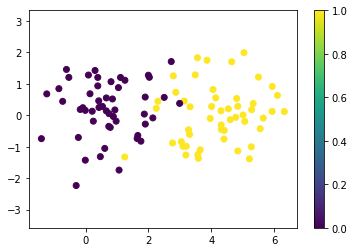

In [2]:
np.random.seed(3)
dataset = make_blobs(centers=2, n_features=1)
X, y = dataset
plt.scatter(X[:,0], np.random.randn(len(X)), c=y)
plt.colorbar()
plt.axis('equal');



## Build a simple model

Suppose we wanted to build a model that predicted the probability that a given X value was a '1'

We could divide the X values into regions and count...

In [3]:
data = pd.concat([
    pd.DataFrame(X, columns=['x']),
    pd.Series(y, name='target')
], axis=1)
data.head()

,x,target
0,3.588248,1
1,4.401520,1
2,-0.847535,0
3,4.313573,1
4,3.646539,1


In [4]:
data['bin'] = pd.cut(data.x, 4)
data.head()

,x,target,bin
0,3.588248,1,"(2.459, 4.39]"
1,4.401520,1,"(4.39, 6.321]"
2,-0.847535,0,"(-1.411, 0.528]"
3,4.313573,1,"(2.459, 4.39]"
4,3.646539,1,"(2.459, 4.39]"


In [5]:
predictions = data.groupby('bin').target.mean()
predictions

bin
(-1.411, 0.528]    0.000000
(0.528, 2.459]     0.107143
(2.459, 4.39]      0.888889
(4.39, 6.321]      1.000000
Name: target, dtype: float64

So our model says that if x is:

- Less than 0.528, 0% chance the target is 1
- Between .528 and 2.459, 11% chance the target is 1
- Between 2.459 and 4.39, 89% chance the target is 1
- Greater than 4.39, 100% chance the target is 1

The basis for the predictions is the number of observations in each of our 'bins':

In [6]:
support = data.groupby('bin').target.count()
support

bin
(-1.411, 0.528]    22
(0.528, 2.459]     28
(2.459, 4.39]      27
(4.39, 6.321]      23
Name: target, dtype: int64

In [7]:
points_per_bin = support.mean()
points_per_bin

25.0

# Adding features

So what happens if we add more features (dimensions)?

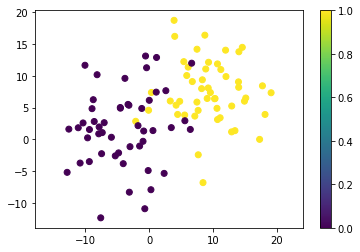

In [8]:
dataset = make_blobs(centers=2, n_features=2, cluster_std=5)
X, y = dataset
plt.scatter(X[:,0], X[:,1], c=y)
plt.colorbar()
plt.axis('equal');



# Simple model

When we come up with our bins, we have to create them in *2* dimensions now:

In [9]:
data = pd.concat([
    pd.DataFrame(X, columns=['x', 'y']),
    pd.Series(y, name='target')
], axis=1)
data.head()
data['bin_x'] = pd.cut(data.x, 4)
data['bin_y'] = pd.cut(data.y, 4)
data.head()

,x,y,target,bin_x,bin_y
0,4.782815,5.971820,1,"(3.121, 11.12]","(3.188, 10.934]"
1,-9.377344,1.548172,0,"(-12.91, -4.879]","(-4.557, 3.188]"
2,9.253301,8.070571,1,"(3.121, 11.12]","(3.188, 10.934]"
3,2.339790,-5.329929,0,"(-4.879, 3.121]","(-12.334, -4.557]"
4,-0.576820,13.081431,0,"(-4.879, 3.121]","(10.934, 18.68]"


In [10]:
predictions = data.groupby(['bin_x', 'bin_y']).target.mean()
predictions

bin_x             bin_y            
(-12.91, -4.879]  (-12.334, -4.557]    0.000000
                  (-4.557, 3.188]      0.000000
                  (3.188, 10.934]      0.000000
                  (10.934, 18.68]      0.000000
(-4.879, 3.121]   (-12.334, -4.557]    0.000000
                  (-4.557, 3.188]      0.111111
                  (3.188, 10.934]      0.181818
                  (10.934, 18.68]      0.000000
(3.121, 11.12]    (-12.334, -4.557]    1.000000
                  (-4.557, 3.188]      0.400000
                  (3.188, 10.934]      1.000000
                  (10.934, 18.68]      0.900000
(11.12, 19.119]   (-12.334, -4.557]         NaN
                  (-4.557, 3.188]      1.000000
                  (3.188, 10.934]      1.000000
                  (10.934, 18.68]      1.000000
Name: target, dtype: float64

We can make a model, but our support has become **sparse**. One bin in particular `(11.12, 19.119], (-12.334, -4.557]` has no samples at all.

In [11]:
support = data.groupby(['bin_x', 'bin_y']).target.count()
support, len(support)

(bin_x             bin_y            
 (-12.91, -4.879]  (-12.334, -4.557]     2
                   (-4.557, 3.188]      15
                   (3.188, 10.934]       3
                   (10.934, 18.68]       1
 (-4.879, 3.121]   (-12.334, -4.557]     5
                   (-4.557, 3.188]       9
                   (3.188, 10.934]      11
                   (10.934, 18.68]       3
 (3.121, 11.12]    (-12.334, -4.557]     1
                   (-4.557, 3.188]       5
                   (3.188, 10.934]      18
                   (10.934, 18.68]      10
 (11.12, 19.119]   (-4.557, 3.188]       3
                   (3.188, 10.934]      10
                   (10.934, 18.68]       4
 Name: target, dtype: int64, 15)

# As we increase the number of dimensions without increasing the number of samples, our data becomes very _sparse_ and hard to model

In [12]:
avg_density = len(data) / 16
avg_density

6.25

# We need to select the *correct* number of features

- We must have enough information to detect the features which cause changes in the output
- ... **without** making our data so sparse we can't detect the patterns

"Rules of thumb" vary on this, but I've seen 10-50 as reasonable minimum number of samples per feature.